### Tutors - expected math exam results

##### Задача:

Предсказать средний балл на экзамене по математике, который получают ученики репетиторов( не применяя библиотеки sklearn) из датасета test.csv. Даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

##### Наименование файлов с данными

train.csv - обучающий датасет
test.csv - тестовый датасет

##### Целевая переменная

mean_exam_points - средний балл на экзамене по математике 

##### Метрика для оценки 

Коэффициент детерминации 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as R2

In [2]:
# Загрузка тренировочных и тестовых данных
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
# Целевая переменная
TARGET_NAME = 'mean_exam_points'

#### Обзор обучающего и тренировочного датасетов

In [3]:
data_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [5]:
data_train.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


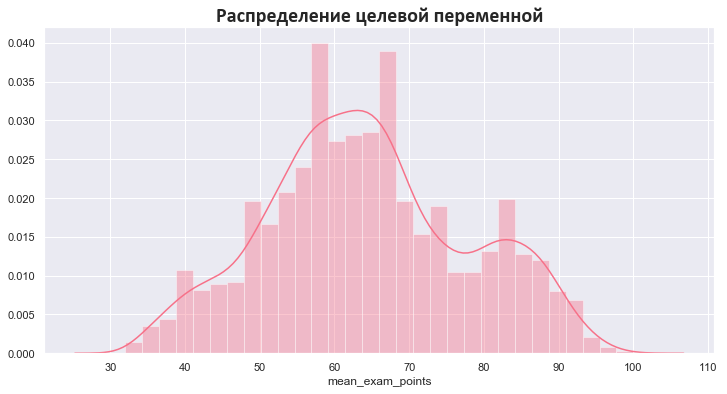

In [6]:
title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
label_dict = {'fontsize': '14', 'family': 'Calibri'}

plt.figure(figsize=(12, 6))
sns.distplot(data_train[TARGET_NAME], bins=30)
plt.title('Распределение целевой переменной', fontdict=title_dict);

In [7]:
FEATURES = data_train.columns.drop(TARGET_NAME).drop('Id')

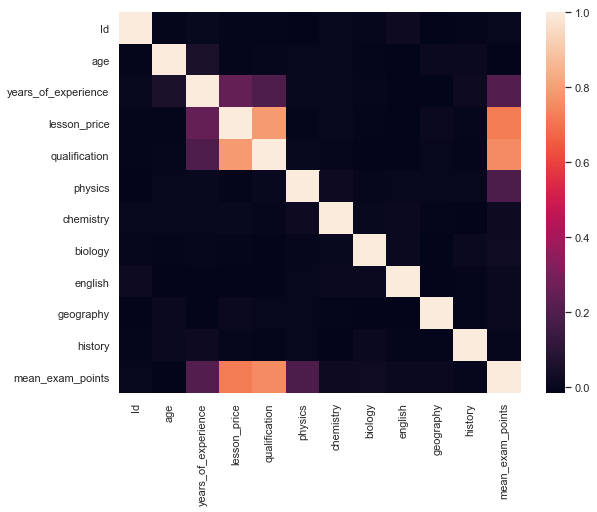

In [8]:
correlations_data = data_train.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlations_data, xticklabels=correlations_data.columns.values, yticklabels=correlations_data.columns.values)

#### Feature engineering

In [9]:
#средний прайс в зависимости от классификации и опыта работы
def add_stat1(df):
    df['lvl'] = df['years_of_experience'].apply(lambda x: 'Junior lvl' if x<3 else ('Middle lvl' if x>=3 and x<6 else 'Senior lvl'))
    stat1 = df.groupby(['qualification', 'lvl'], as_index=False)[['lesson_price']].mean().round().rename(columns={'lesson_price':'mean_price'})
    df = pd.merge(df, stat1, on=['qualification', 'lvl'], how='left')
    df = df.join(pd.get_dummies(df['lvl'],drop_first = True))
    df = df.drop(['lvl'], axis=1)
    return df

In [10]:
data_train = add_stat1(data_train)
data_train.head(10)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,mean_price,Middle lvl,Senior lvl
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,1340.0,0,0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0,2581.0,1,0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1340.0,0,0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,1346.0,1,0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,1340.0,0,0
5,5,33.0,4.0,1650.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,1346.0,1,0
6,6,53.0,1.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,1340.0,0,0
7,7,60.0,3.0,1800.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1779.0,1,0
8,8,39.0,1.0,1200.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,57.0,1340.0,0,0
9,9,49.0,5.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,1346.0,1,0


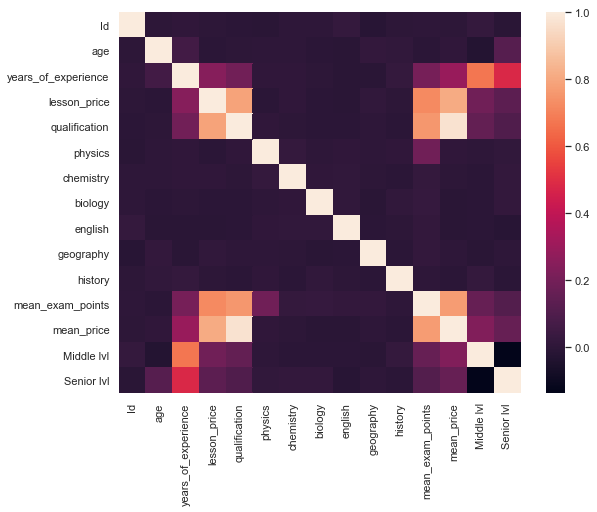

In [11]:
correlations_data = data_train.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlations_data, xticklabels=correlations_data.columns.values, yticklabels=correlations_data.columns.values)

In [12]:
X = np.array(data_train.drop(columns=TARGET_NAME).drop(columns='Id'))
y = np.array(data_train[TARGET_NAME])

#### Реализация XGBoost

In [13]:
class RegressionTreeGain:
        
    def __init__(self, max_depth=3, lmd=1.0, gmm=0.1, min_size=5):
        
        self.max_depth = max_depth
        self.gmm = gmm
        self.lmd = lmd
        self.left = None
        self.right = None
        self.feature_idx = -1
        self.feature_threshold = 0
        self.value = -1e9
        self.min_size = min_size
        
            
    def fit(self, X, y):
        
        N = X.shape[0]
        N1 = X.shape[0]
        N2 = 0
        idx = 0
        thres = 0     
        x = 0.0
        best_gain = -self.gmm
              
        if self.value == -1e9:
            self.value = y.mean()
        
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        if self.max_depth <= 1:
            return
        
        dim_shape = X.shape[1]
        
        left_value = 0
        right_value = 0
        
        # начинаем процесс обучения
               
        for feat in range(dim_shape):
            
            idxs = np.argsort(X[:, feat])
             
            gl,gr = y.sum(),0.0

            N1, N2, thres = N, 0, 0
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                gl -= y[idx]
                gr += y[idx]
                
                # считаем гейн
                gn = (gl**2) / (N1 + self.lmd)  + (gr**2) / (N2 + self.lmd)
                gn -= ((gl + gr)**2) / (N1 + N2 + self.lmd) + self.gmm
                
                if thres < N - 1 and x == X[idxs[thres + 1], feat]:
                    thres += 1
                    continue
                
                # проверяем условия на гейн
                if (gn > best_gain) and (min(N1,N2) > self.min_size):
                    
                    flag = 1
                    best_gain = gn
                    left_value = -gl / (N1 + self.lmd)
                    right_value = -gr / (N2 + self.lmd)
                    
                    self.feature_idx = feat
                    self.feature_threshold = x

                thres += 1
        
        self.gain = best_gain
        if self.feature_idx == -1:
            return
                
        self.left = RegressionTreeGain(max_depth=self.max_depth - 1, gmm=self.gmm, lmd=self.lmd)
        self.left.value = left_value
        self.right = RegressionTreeGain(max_depth=self.max_depth - 1, gmm=self.gmm, lmd=self.lmd)
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
        # подрубаем отрицательный гейн
        if (self.left.left == None or self.right.left == None):
            if self.gain < 0.0:
                self.left = None
                self.right = None
                self.feature_idx = -1

    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
             return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

In [14]:
class GradientBoosting():
    

    def __init__(self, n_estimators=100, learning_rate=0.3, max_depth=3, 
                 random_state=17, n_samples = 15, min_size = 5, base_tree='XGBoost'):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.min_size = min_size
        self.loss_by_iter = []
        self.trees_ = []
        self.loss_by_iter_test = []
        self.n_samples = n_samples
        self.base_tree = base_tree

        # хотим как-то регулировать работу алгоритма на поздних итерациях
        # если ошибка застряла, то уменьшаем lr и увеличиваем max_depth
        self.add_to_max_depth = 1
        self.init_mse_board = 1.5
        
    
    def mse(y, y_pred):
        return np.sqrt(np.mean((y - y_pred1)**2))    
    
    
    def fit(self, X, y):
        print (self.base_tree)
        self.X = X
        self.y = y
        b = self.initialization(y)
        
        prediction = b.copy()
        
        for t in tqdm_notebook(range(self.n_estimators)):
                        
            if t == 0:
                resid = y
            else:
                resid = (y - prediction)
                if (mse(temp_resid, resid) < self.init_mse_board):
                    self.init_mse_board /= 1.5
                    self.add_to_max_depth += 1
                    self.learning_rate /= 1.1
                                
            
            if self.base_tree == 'XGBoost':
                tree = RegressionTreeGain(max_depth=self.max_depth+self.add_to_max_depth, min_size = self.min_size)
                resid = -resid
                
            tree.fit(X, resid)
            b = tree.predict(X).reshape([X.shape[0]])
            self.trees_.append(tree)
            prediction += self.learning_rate * b
            temp_resid = resid

        return self
    
    def predict(self, X):
        
        # сначала прогноз – это просто вектор из средних значений ответов на обучении
        pred = np.ones([X.shape[0]]) * np.mean(self.y)
        # добавляем прогнозы деревьев
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0]])
            
        return pred

### Обучение модели

In [17]:
XGBoost = GradientBoosting(max_depth=5, n_estimators=300, base_tree='XGBoost')
XGBoost.fit(X, y)
predict_train = XGBoost.predict(X)
print(f'R2 на трейне {R2(y, predict_train)}')

XGBoost



R2 на трейне 0.8584634019410009


#### Предскажем данные на тесте

In [20]:
data_test = add_stat1(data_test)
data_train.head(10)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,mean_price,Middle lvl,Senior lvl
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,1340.0,0,0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0,2581.0,1,0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1340.0,0,0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,1346.0,1,0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,1340.0,0,0
5,5,33.0,4.0,1650.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,1346.0,1,0
6,6,53.0,1.0,2100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,1340.0,0,0
7,7,60.0,3.0,1800.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,1779.0,1,0
8,8,39.0,1.0,1200.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,57.0,1340.0,0,0
9,9,49.0,5.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,1346.0,1,0


In [21]:
X_test = np.array(data_test.drop(columns='Id'))

In [22]:
X_test.shape

(10000, 13)

In [23]:
predict_test = XGBoost.predict(X_test)

In [24]:
data_test[TARGET_NAME] = predict_test
data_test[TARGET_NAME] = data_test[TARGET_NAME].astype('float64')

In [25]:
# Сохраняем полученные предсказания
data_test.loc[:, ['Id', TARGET_NAME]].to_csv('data/ANovikov_predictions.csv', index=None)